# Engineering Predictive Alpha Factors

This notebook illustrates the following steps:

1. Select the adjusted open, high, low, and close prices as well as the volume for all tickers from the Quandl Wiki data that you downloaded and simplified for the last milestone for the 2007-2016 time period. Looking ahead, we will use 2014-2016 as our 'out-of-sample' period to test the performance of a strategy based on a machine learning model selected using data from preceding periods.
2. Compute the dollar volume as the product of closing price and trading volume; then select the stocks with at least eight years of data and the lowest average daily rank for this metric. 
3. Compute daily returns and keep only 'inliers' with values between -100% and + 100% as a basic check against data error.
4. Now we're ready to compute financial features. The Alpha Factory Library listed among the resources below illustrates how to compute a broad range of those using pandas and TA-Lib. We will list a few examples; feel free to explore and evaluate the various TA-Lib indicators.
    - Compute **historical returns** for various time ranges such as 1, 3, 5, 10, 21 trading days, as well as longer periods like 2, 3, 6 and 12 months.
    - Use TA-Lib's **Bollinger Band** indicator to create features that anticipate **mean-reversion**.
    - Select some indicators from TA-Lib's **momentum** indicators family such as
        - the Average Directional Movement Index (ADX), 
        - the Moving Average Convergence Divergence (MACD), 
        - the Relative Strength Index (RSI), 
        - the Balance of Power (BOP) indictor, or 
        - the Money Flow Index (MFI).
    - Compute TA-Lib **volume** indicators like On Balance Volume (OBV) or the Chaikin A/D Oscillator (ADOSC)
    - Create volatility metrics such as the Normalized Average True Range (NATR).
    - Compute rolling factor betas using the five Fama-French risk factors for different rolling windows of three and 12 months (see resources below).
    - Compute the outcome variable that we will aim to predict, namely the 1-day forward returns.

## Usage tips

- If you experience resource constraints (suddenly restarting Kernel), increase the memory available for Docker Desktop (> Settings > Advanced). If this not possible or you experienced prolonged execution times, reduce the scope of the exercise. The easiest way to do so is to select fewer stocks or a shorter time period, or both.
- You may want to persist intermediate results so you can recover quickly in case something goes wrong. There's an example under the first 'Persist Results' subsection.

## Imports & Settings

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
%matplotlib inline

from pathlib import Path
import numpy as np
import pandas as pd
import pandas_datareader.data as web

import statsmodels.api as sm
from statsmodels.regression.rolling import RollingOLS
from sklearn.preprocessing import scale
import talib
from talib import MA_Type

import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
sns.set_style('whitegrid')
idx = pd.IndexSlice
deciles = np.arange(.1, 1, .1).round(1)

## Load Data

In [4]:
with pd.HDFStore('data.h5') as store:
    data = (store['data']
          .sort_index()
          .loc[idx['2006':'2016', :], :])

In [5]:
data.info(show_counts = True)

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 7531907 entries, (Timestamp('2006-01-02 00:00:00'), 'TAM') to (Timestamp('2016-12-30 00:00:00'), 'ZUMZ')
Data columns (total 5 columns):
 #   Column  Non-Null Count    Dtype  
---  ------  --------------    -----  
 0   open    7531907 non-null  float64
 1   high    7531907 non-null  float64
 2   low     7531907 non-null  float64
 3   close   7531907 non-null  float64
 4   volume  7531907 non-null  float64
dtypes: float64(5)
memory usage: 316.4+ MB


In [6]:
print(f"# Tickers: {len(data.index.unique('ticker')):,.0f} | # Dates: {len(data.index.unique('date')):,.0f}")

# Tickers: 3,186 | # Dates: 2,846


## Remove outliers based on daily returns

In [7]:
simple_returns = data.groupby('ticker').close.pct_change()

In [29]:
def compute_log_returns(close, lag):
    return np.log(close) - np.log(close.shift(lag))   

log_returns = data.groupby('ticker').close.apply(compute_log_returns, lag = 1)

In [9]:
simple_returns.describe(percentiles=[.00001, .0001, .001, .999, .9999, .99999]).iloc[1:]

mean         0.000797
std          0.139972
min         -0.993615
0.001%      -0.713063
0.01%       -0.396673
0.1%        -0.192885
50%          0.000000
99.9%        0.232877
99.99%       0.587008
99.999%      1.891319
max        283.000000
Name: close, dtype: float64

In [10]:
simple_outliers = simple_returns[(simple_returns < simple_returns.quantile(.00001)) |
                         (simple_returns > simple_returns.quantile(.99999))]

In [11]:
print(f'# Observations: {len(simple_outliers):,.0f} | # Tickers: {len(simple_outliers.index.unique("ticker")):,.0f}')

# Observations: 152 | # Tickers: 90


In [12]:
data = data.drop(simple_outliers.index.unique('ticker'), level='ticker')

## Select 500 most traded stocks

Compute the dollar volume as the product of the adjusted close price and the adjusted volume:

In [13]:
dv = data.close.mul(data.volume)

In [14]:
dollar_vol_ma = (dv
                 .unstack('ticker')
                 .dropna(thresh=8*252, axis=1)
                 .rolling(window=21, min_periods=1) 
                 .mean())

In [15]:
data['dollar_vol_rank'] = (dollar_vol_ma
                           .rank(axis=1, ascending=False)
                           .stack('ticker'))

In [16]:
top500 = (data
          .groupby('date', group_keys = False)
          .apply(lambda x: x.dollar_vol_rank.nsmallest(500)))

In [17]:
data = data.loc[top500.index, :].sort_index().copy()

In [18]:
data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 1384536 entries, (Timestamp('2006-01-03 00:00:00'), 'A') to (Timestamp('2016-12-30 00:00:00'), 'ZION')
Data columns (total 6 columns):
 #   Column           Non-Null Count    Dtype  
---  ------           --------------    -----  
 0   open             1384536 non-null  float64
 1   high             1384536 non-null  float64
 2   low              1384536 non-null  float64
 3   close            1384536 non-null  float64
 4   volume           1384536 non-null  float64
 5   dollar_vol_rank  1384536 non-null  float64
dtypes: float64(6)
memory usage: 68.8+ MB


### Sample price data to illustrate factors

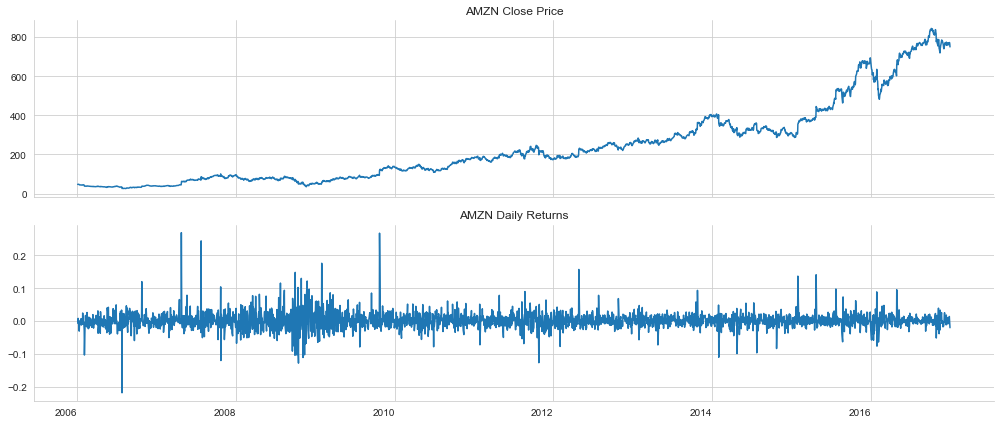

In [257]:
ticker = 'AMZN'

fig, axes = plt.subplots(nrows=2, figsize=(14, 6), sharex=True) # create figure with 2 axes
s = data.loc[idx[:, ticker], 'close'].droplevel('ticker') # select closing prices for ticker
s.plot(rot=0, ax=axes[0], title=f'{ticker} Close Price') # plot prices on first axes
s.pct_change().plot(rot=0, ax=axes[1], title=f'{ticker} Daily Returns') # add returns to second axis
axes[1].set_xlabel('')
sns.despine()
fig.tight_layout()

In [258]:
price_sample = data.loc[idx[:, ticker], :].reset_index('ticker', drop=True)

## Compute returns

Group data by ticker

In [19]:
by_ticker = data.groupby(level='ticker')

### Historical Returns

In [20]:
T = [1, 3, 5, 10, 21, 42, 63, 126, 252]

In [34]:
for t in T:
    data[f'ret_{t:02}'] = by_ticker.close.apply(compute_log_returns, lag = t)

In [33]:
data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 1384536 entries, (Timestamp('2006-01-03 00:00:00'), 'A') to (Timestamp('2016-12-30 00:00:00'), 'ZION')
Data columns (total 15 columns):
 #   Column           Non-Null Count    Dtype  
---  ------           --------------    -----  
 0   open             1384536 non-null  float64
 1   high             1384536 non-null  float64
 2   low              1384536 non-null  float64
 3   close            1384536 non-null  float64
 4   volume           1384536 non-null  float64
 5   dollar_vol_rank  1384536 non-null  float64
 6   ret_01           1383316 non-null  float64
 7   ret_03           1380952 non-null  float64
 8   ret_05           1378628 non-null  float64
 9   ret_10           1373010 non-null  float64
 10  ret_21           1361161 non-null  float64
 11  ret_42           1340253 non-null  float64
 12  ret_63           1320545 non-null  float64
 13  ret_126          1266091 non-null  float64
 14  ret_252          1168187 non-null  float6

### Forward Returns

In [262]:
data['ret_fwd'] = by_ticker.ret_01.shift(-1) 
data = data.dropna(subset=['ret_fwd'])

## Bollinger Bands

In [263]:
df = price_sample.loc['2012', ['close']]

In [264]:
s = talib.BBANDS(df.close,   
                 timeperiod=21,
                 nbdevup=2,    
                 nbdevdn=2,    
                 matype=MA_Type.SMA      
                 ) 

In [265]:
bb_bands = ['upper', 'middle', 'lower']

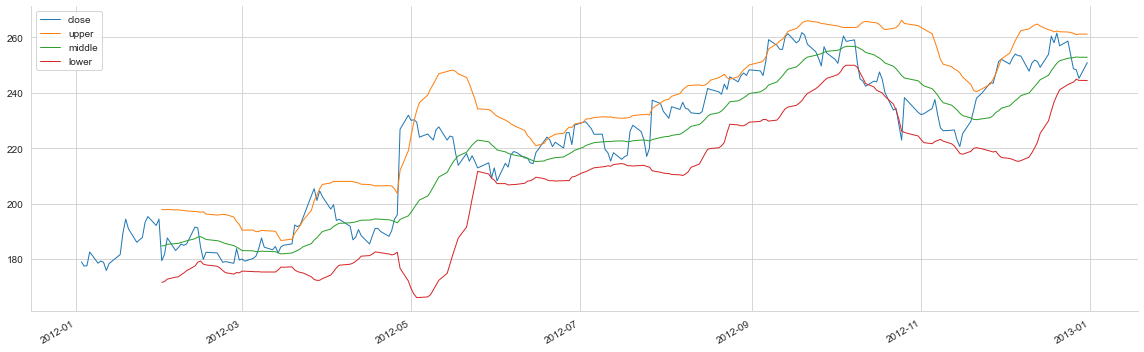

In [266]:
df = price_sample.loc['2012', ['close']]
df = df.assign(**dict(zip(bb_bands, s)))
ax = df.loc[:, ['close'] + bb_bands].plot(figsize=(16, 5), lw=1)

ax.set_xlabel('')
sns.despine()
plt.tight_layout();

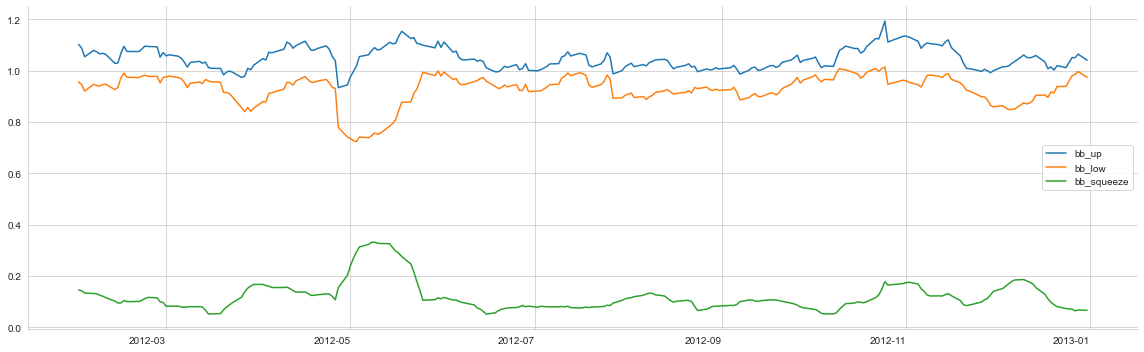

In [267]:
fig, ax = plt.subplots(figsize=(16,5))
df.upper.div(df.close).plot(ax=ax, label='bb_up')
df.lower.div(df.close).plot(ax=ax, label='bb_low')
df.upper.sub(df.lower).div(df.close).plot(ax=ax, label='bb_squeeze', rot=0)

plt.legend()
ax.set_xlabel('')
sns.despine()
plt.tight_layout();

In [268]:
def compute_bb_indicators(close):
    high, mid, low = talib.BBANDS(close, 
                                  timeperiod=21,
                                  matype=MA_Type.SMA)
    bb_up = high / close -1 # normalize with respect to close
    bb_low = low / close -1 # normalize with respect to close
    squeeze = (high - low) / close
    return pd.DataFrame({'BB_UP': bb_up, 
                         'BB_LOW': bb_low, 
                         'BB_SQUEEZE': squeeze}, 
                        index=close.index)

In [269]:
data = (data.join(data
                  .groupby(level='ticker')
                  .close
                  .apply(compute_bb_indicators)))

### Visualize Distribution

In [270]:
bb_indicators = ['BB_UP', 'BB_LOW', 'BB_SQUEEZE']

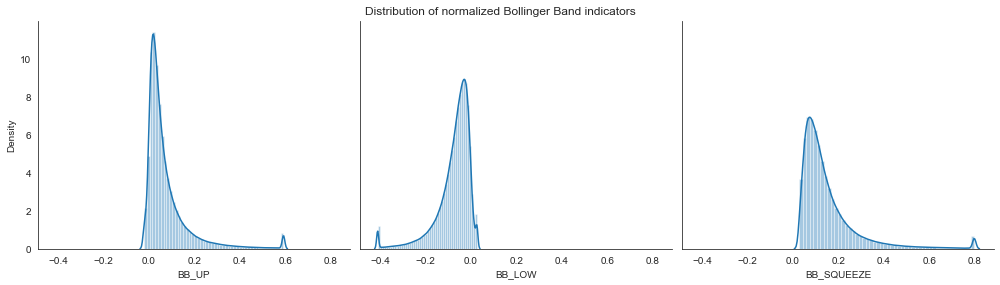

In [271]:
q = .01
with sns.axes_style('white'):
    fig, axes = plt.subplots(ncols=3, figsize=(14, 4), sharey=True, sharex=True)
    df_ = data[bb_indicators]
    df_ = df_.clip(df_.quantile(q), 
                   df_.quantile(1-q), axis=1)
    for i, indicator in enumerate(bb_indicators):
        sns.distplot(df_[indicator], ax=axes[i])
    fig.suptitle('Distribution of normalized Bollinger Band indicators', fontsize=12)

    sns.despine()
    fig.tight_layout()
    fig.subplots_adjust(top=.93);

### Plot outlier price series

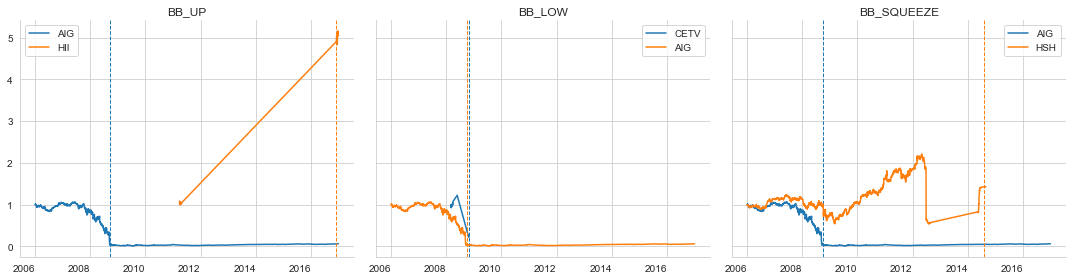

In [272]:
ncols = len(bb_indicators)
fig, axes = plt.subplots(ncols=ncols, figsize=(5*ncols, 4), sharey=True)
for i, indicator in enumerate(bb_indicators):
    # plot price series for ticker with highest value 
    date, ticker = data[indicator].nlargest(1).index[0] # select ticker & data with highest value for indicator
    p = data.loc[idx[:, ticker], :].close.reset_index('ticker', drop=True)
    p = p.div(p.dropna().iloc[0]) # normalize price series so it starts at 1
    p.plot(ax=axes[i], label=ticker, rot=0)
    c = axes[i].get_lines()[-1].get_color()
    axes[i].axvline(date, ls='--', c=c, lw=1)
    
    # repeat for ticker with lowest value
    date, ticker = data[indicator].nsmallest(1).index[0] # select ticker & date with lowest value for indicator
    p = data.loc[idx[:, ticker], :].close.reset_index('ticker', drop=True)
    p = p.div(p.dropna().iloc[0])
    p.plot(ax=axes[i], label=ticker, rot=0)    
    c = axes[i].get_lines()[-1].get_color()
    axes[i].axvline(date, ls='--', c=c, lw=1)
    axes[i].set_title(indicator.upper())
    axes[i].legend()
    axes[i].set_xlabel('')

sns.despine()
fig.tight_layout();

## Hilbert Transform - Instantaneous Trendline

In [273]:
df = price_sample.loc['2012', ['close']]
df['HT_TRENDLINE'] = talib.HT_TRENDLINE(df.close)

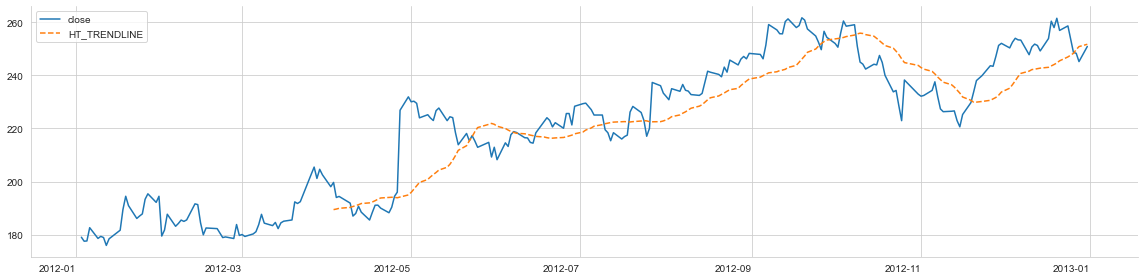

In [274]:
ax = df.plot(figsize=(16, 4), style=['-', '--'], rot=0)

ax.set_xlabel('')
sns.despine()
plt.tight_layout();

In [275]:
data['HT'] = (data
              .groupby(level='ticker', group_keys=False)
              .close
              .apply(talib.HT_TRENDLINE)
              .div(data.close).sub(1))

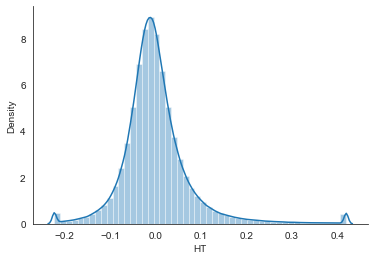

In [276]:
q=0.005
with sns.axes_style('white'):
    sns.distplot(data.HT.clip(data.HT.quantile(q), data.HT.quantile(1-q)))
    sns.despine();

## Parabolic SAR

In [277]:
df = price_sample.loc['2012', ['close', 'high', 'low']]
df['SAR'] = talib.SAR(df.high, df.low, 
                      acceleration=0.02, # common value
                      maximum=0.2)    

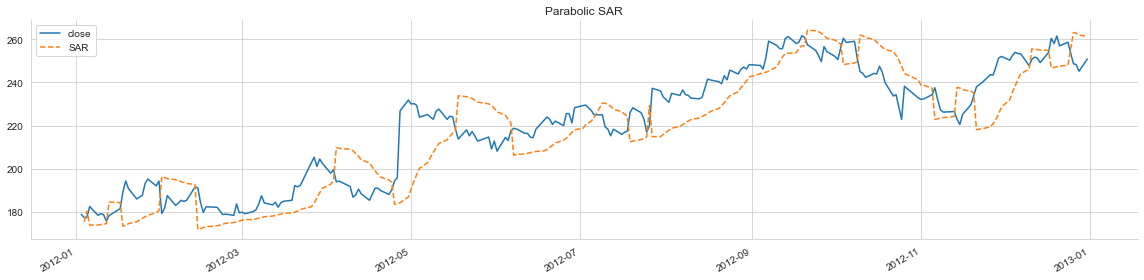

In [278]:
ax = df[['close', 'SAR']].plot(figsize=(16, 4), style=['-', '--'], title='Parabolic SAR')
ax.set_xlabel('')
sns.despine()
plt.tight_layout();

In [279]:
def compute_sar_indicator(x):
    sar = talib.SAR(x.high, 
                    x.low,
                    acceleration=.02,
                    maximum=.2)
    return sar/x.close - 1

In [280]:
data['SAR'] = (data.groupby(level='ticker', group_keys=False)
                  .apply(compute_sar_indicator))

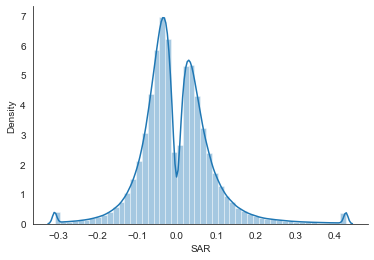

In [281]:
q=0.005
with sns.axes_style('white'):
    sns.distplot(data.SAR.clip(data.SAR.quantile(q), data.SAR.quantile(1-q)))
    sns.despine()

## Momentum Indicators

TA-Lib offers the following choices - feel free to experiment with as many as you like (but you don't have to..):

|Function|             Name|
|:---|:---|
|PLUS_DM|              Plus Directional Movement|
|MINUS_DM|             Minus Directional Movement|
|PLUS_DI|              Plus Directional Indicator|
|MINUS_DI|             Minus Directional Indicator|
|DX|                   Directional Movement Index|
|ADX|                  Average Directional Movement Index|
|ADXR|                 Average Directional Movement Index Rating|
|APO|                  Absolute Price Oscillator|
|PPO|                  Percentage Price Oscillator|
|AROON|                Aroon|
|AROONOSC|             Aroon Oscillator|
|BOP|                  Balance Of Power|
|CCI|                  Commodity Channel Index|
|CMO|                  Chande Momentum Oscillator|
|MACD|                 Moving Average Convergence/Divergence|
|MACDEXT|              MACD with controllable MA type|
|MACDFIX|              Moving Average Convergence/Divergence Fix 12/26|
|MFI|                  Money Flow Index|
|MOM|                  Momentum|
|RSI|                  Relative Strength Index|
|STOCH|                Stochastic|
|STOCHF|               Stochastic Fast|
|STOCHRSI|             Stochastic Relative Strength Index|
|TRIX|                 1-day Rate-Of-Change (ROC) of a Triple Smooth EMA|
|ULTOSC|               Ultimate Oscillator|
|WILLR|                Williams' %R|

### Average Directional Movement Index (ADX)

The ADX combines of two other indicators, namely the positive and directional indicators (PLUS_DI and MINUS_DI), which in turn build on the positive and directional movement (PLUS_DM and MINUS_DM). For additional details see [Wikipdia](https://en.wikipedia.org/wiki/Average_directional_movement_index) and [Investopedia](https://www.investopedia.com/articles/trading/07/adx-trend-indicator.asp).

In [282]:
df = price_sample.loc['2012': '2013', ['high', 'low', 'close']]

In [283]:
df['PLUS_DM'] = talib.PLUS_DM(df.high, df.low, timeperiod=10)
df['MINUS_DM'] = talib.MINUS_DM(df.high, df.low, timeperiod=10)

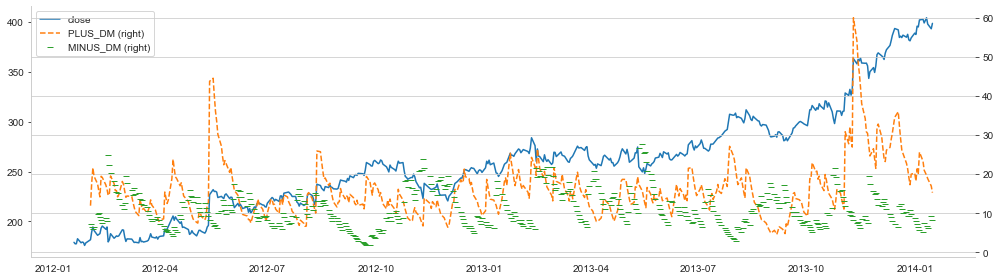

In [284]:
ax = df[['close', 'PLUS_DM', 'MINUS_DM']].plot(figsize=(14, 4),
                                               secondary_y=[
                                                   'PLUS_DM', 'MINUS_DM'],
                                               style=['-', '--', '_'],
                                              rot=0)
ax.set_xlabel('')
sns.despine()
plt.tight_layout()

In [285]:
df = price_sample.loc['2012': '2013', ['high', 'low', 'close']]

In [286]:
df['PLUS_DI'] = talib.PLUS_DI(df.high, df.low, df.close, timeperiod=14)
df['MINUS_DI'] = talib.MINUS_DI(df.high, df.low, df.close, timeperiod=14)

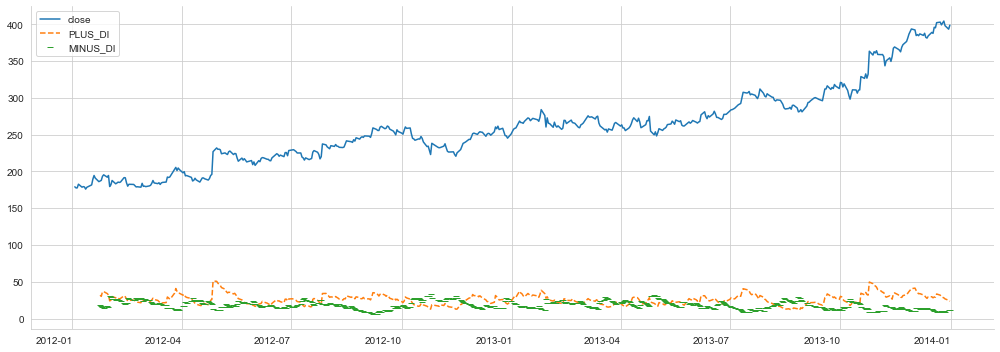

In [287]:
ax = df[['close', 'PLUS_DI', 'MINUS_DI']].plot(figsize=(14, 5), style=['-', '--', '_'], rot=0)

ax.set_xlabel('')
sns.despine()
plt.tight_layout();

In [288]:
df = price_sample.loc[:, ['high', 'low', 'close']]

In [289]:
df['ADX'] = talib.ADX(df.high, 
                      df.low, 
                      df.close, 
                      timeperiod=14)

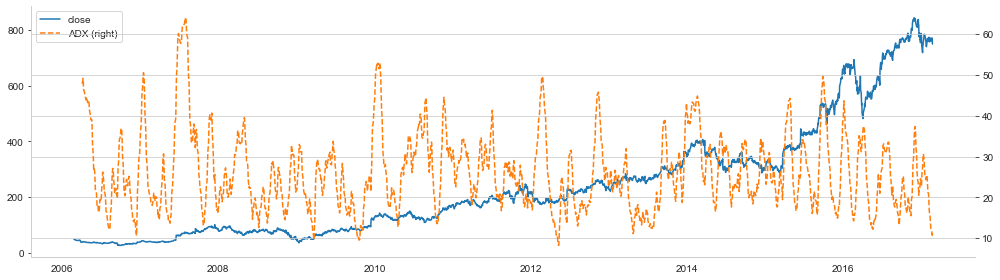

In [290]:
ax = df[['close', 'ADX']].plot(figsize=(14, 4), secondary_y='ADX', style=['-', '--'], rot=0)
ax.set_xlabel('')
sns.despine()
plt.tight_layout();

In [291]:
def compute_adx(x):
    return talib.ADX(x.high, 
                    x.low,
                    x.close,
                    timeperiod=14)

In [292]:
data['ADX'] = (data.groupby(level='ticker', group_keys=False)
                  .apply(compute_adx))

#### Visualize distribution

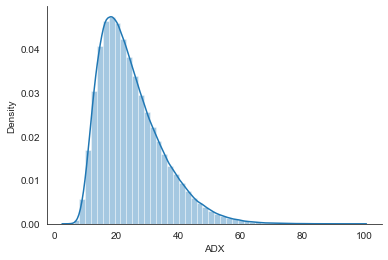

In [293]:
with sns.axes_style("white"):
    sns.distplot(data.ADX)
    sns.despine();

In [294]:
df = price_sample.loc[:, ['high', 'low', 'close']]

In [295]:
df['ADXR'] = talib.ADXR(df.high,
                        df.low,
                        df.close,
                        timeperiod=14)

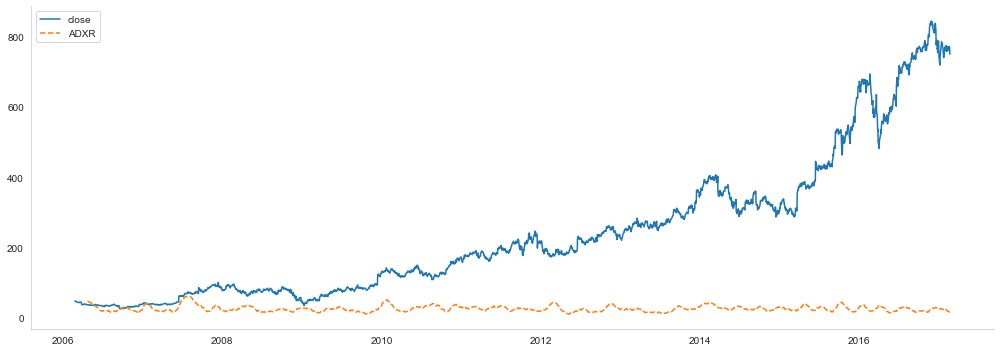

In [296]:
ax = df[['close', 'ADXR']].plot(figsize=(14, 5),
                                secondary_y='ADX',
                                style=['-', '--'], rot=0)
ax.set_xlabel('')
sns.despine()
plt.tight_layout()

In [297]:
def compute_adxr(x, timeperiod=14):
    return talib.ADXR(x.high, 
                    x.low,
                    x.close,
                    timeperiod=timeperiod)

In [298]:
data['ADXR'] = (data.groupby(level='ticker', group_keys=False)
                .apply(compute_adxr))

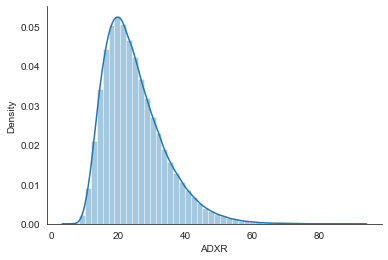

In [299]:
with sns.axes_style('white'):
    sns.distplot(data.ADXR)
    sns.despine();

### Absolute Price Oscillator (APO)

The absolute Price Oscillator (APO) is computed as the difference between two exponential moving averages (EMA) of price series, expressed as an absolute value. The EMA windows usually contain 26 and 12 data points, respectively.

In [300]:
df = price_sample.loc[:, ['close']]

In [301]:
df['APO'] = talib.APO(df.close,
                      fastperiod=12,
                      slowperiod=26,
                      matype=talib.MA_Type.EMA)

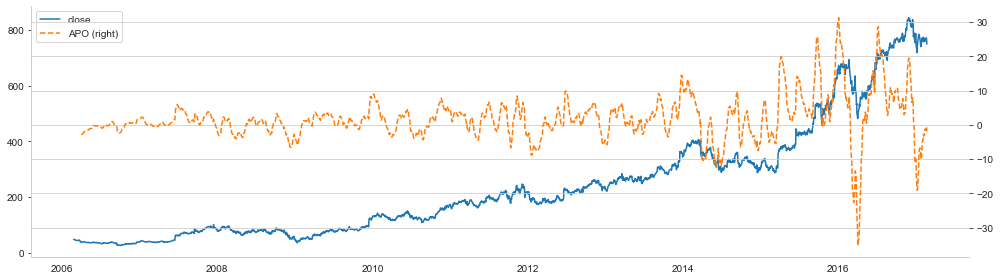

In [302]:
ax = df.plot(figsize=(14,4), secondary_y='APO', rot=0, style=['-', '--'])
ax.set_xlabel('')
sns.despine()
plt.tight_layout();

### Percentage Price Oscillator (PPO)

The Percentage Price Oscillator (APO) is computed as the difference between two exponential moving averages (EMA) of price series, expressed as a percentage value and thus comparable across assets. The EMA windows usually contain 26 and 12 data points, respectively. 

In [303]:
df = price_sample.loc[:, ['close']]

In [304]:
df['PPO'] = talib.PPO(df.close,
                      fastperiod=12,
                      slowperiod=26,
                      matype=talib.MA_Type.EMA)

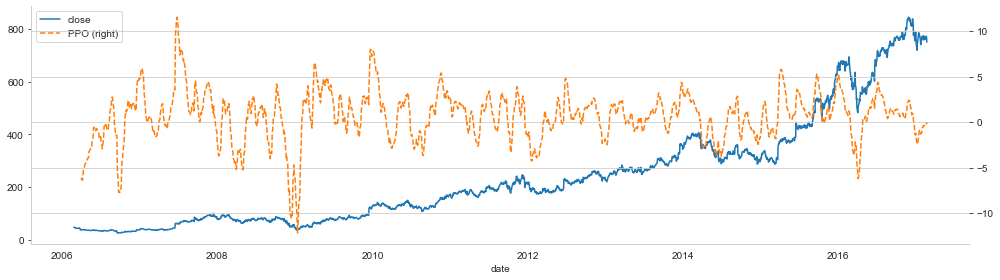

In [305]:
ax = df.plot(figsize=(14,4), secondary_y=['APO', 'PPO'], rot=0,  style=['-', '--'])

ax.set_xlabel('')
sns.despine()
plt.tight_layout();

In [306]:
data['PPO'] = (data.groupby(level='ticker')
               .close
               .apply(talib.PPO, 
                      fastperiod=12, 
                      slowperiod=26, 
                      matype=talib.MA_Type.EMA))

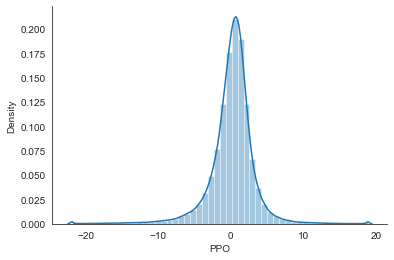

In [307]:
q = 0.001
with sns.axes_style("white"):
    sns.distplot(data.PPO.clip(lower=data.PPO.quantile(q),
                               upper=data.PPO.quantile(1-q)))
    sns.despine()

### Aroon Oscillator

#### Aroon Up/Down Indicator

The indicator measures the time between highs and the time between lows over a time period. It computes an AROON_UP and an AROON_DWN indicator as follows:

$$
\begin{align*}
\text{AROON_UP}&=\frac{T-\text{Periods since T period High}}{T}\times 100\\
\text{AROON_DWN}&=\frac{T-\text{Periods since T period Low}}{T}\times 100
\end{align*}
$$

In [308]:
df = price_sample.loc['2013', ['high', 'low', 'close']]

In [309]:
aroonup, aroondwn = talib.AROON(high=df.high,
                                low=df.low,
                                timeperiod=14)
df['AROON_UP'] = aroonup
df['AROON_DWN'] = aroondwn

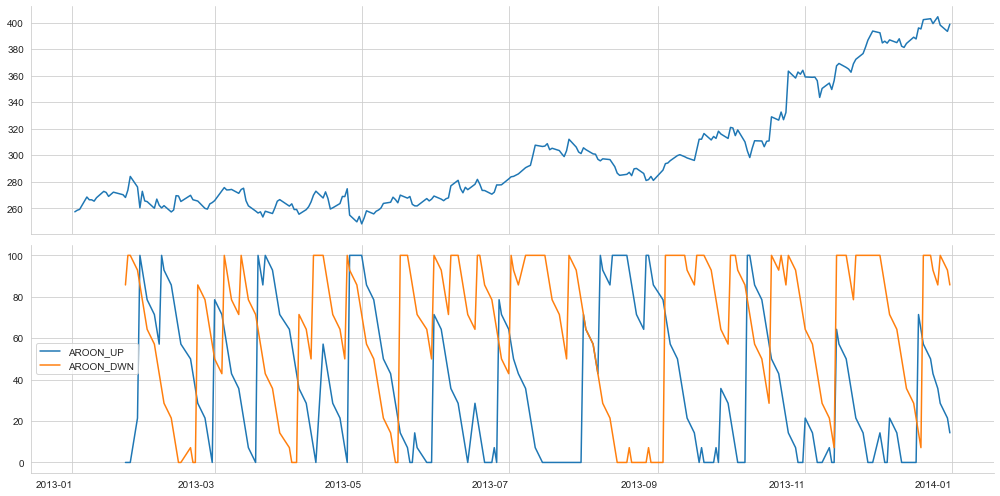

In [310]:
fig, axes = plt.subplots(nrows=2, figsize=(14, 7), sharex=True)
df.close.plot(ax=axes[0], rot=0)
df[['AROON_UP', 'AROON_DWN']].plot(ax=axes[1], rot=0)

axes[1].set_xlabel('')
sns.despine()
plt.tight_layout();

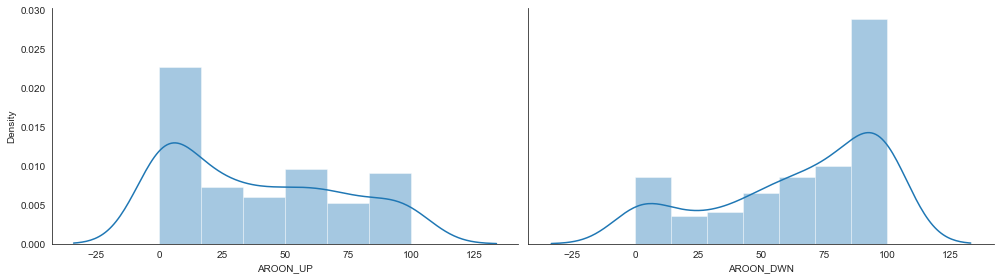

In [311]:
with sns.axes_style("white"):
    fig, axes = plt.subplots(ncols=2, figsize=(14, 4), sharey=True, sharex=True)
    sns.distplot(df.AROON_UP, ax = axes[0])
    sns.distplot(df.AROON_DWN, ax = axes[1])
    sns.despine()
    fig.tight_layout()

In [312]:
def compute_aroon(df):
    aroonup, aroondwn = talib.AROON(high=df.high,
                                low=df.low,
                                timeperiod=14)
    return pd.DataFrame({'AROON_UP': aroonup, 'AROON_DOWN': aroondwn}, index = df.index)

In [313]:
data = (data.join(data
                  .groupby(level='ticker')
                  .apply(compute_aroon)))

#### Aroon Oscillator

The Aroon Oscillator is simply the difference between the Aroon Up and Aroon Down indicators.

In [314]:
df = price_sample.loc['2013', ['high', 'low', 'close']]

In [315]:
df['AROONOSC'] = talib.AROONOSC(high=df.high,
                                low=df.low,
                                timeperiod=14)

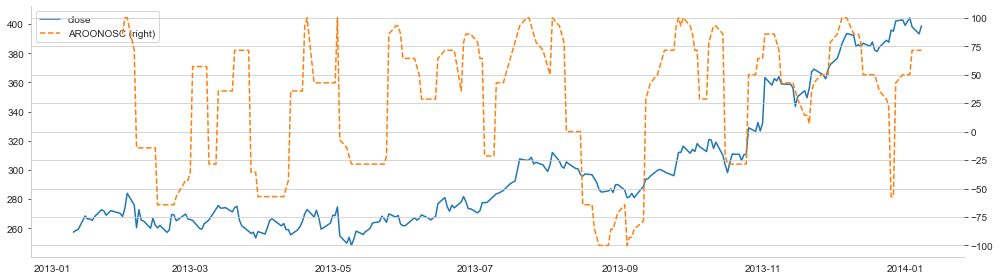

In [316]:
ax = df[['close', 'AROONOSC']].plot(figsize=(14,4), rot=0, style=['-', '--'], secondary_y='AROONOSC')
ax.set_xlabel('')
sns.despine()
plt.tight_layout();

In [317]:
data['AARONOSC'] = (data.groupby('ticker',
                                 group_keys=False)
                    .apply(lambda x: talib.AROONOSC(high=x.high,
                                                    low=x.low,
                                                    timeperiod=14)))

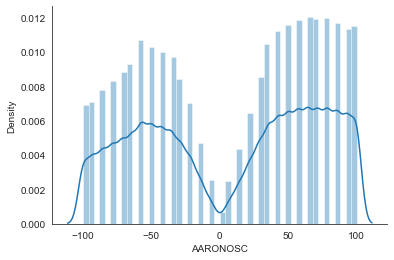

In [318]:
with sns.axes_style("white"):
    sns.distplot(data.AARONOSC)
    sns.despine()

### Balance Of Power (BOP)

The Balance of Power (BOP) intends to measure the strength of buyers relative to sellers in the market by assessing the ability of each side to drive prices. It is computer as the difference between the close and the open price, divided by the difference between the high and the low price: 

$$
\text{BOP}_t= \frac{P_t^\text{Close}-P_t^\text{Open}}{P_t^\text{High}-P_t^\text{Low}}
$$

In [319]:
df = price_sample.loc['2013', ['open', 'high', 'low', 'close']]

In [320]:
df['BOP'] = talib.BOP(open=df.open,
                      high=df.high,
                      low=df.low,
                      close=df.close)

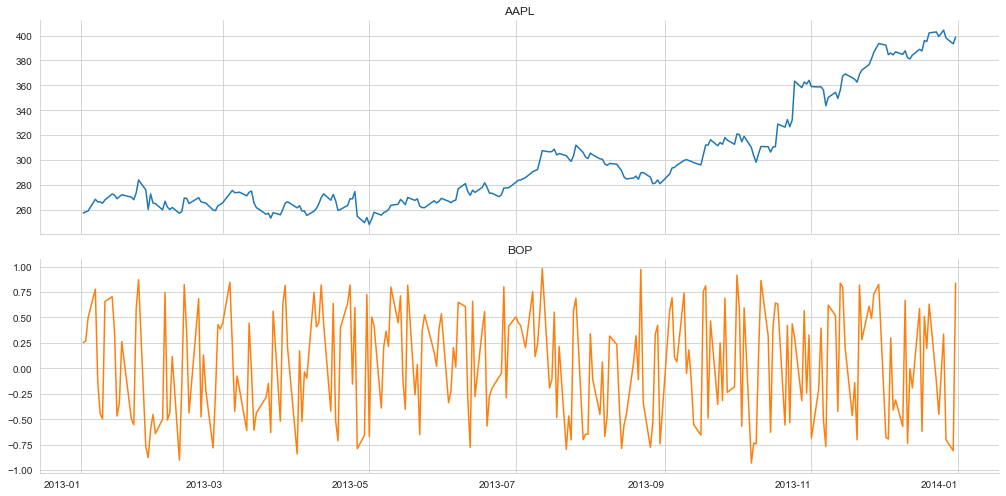

In [321]:
axes = df[['close', 'BOP']].plot(figsize=(14, 7), rot=0, subplots=True, title=['AAPL', 'BOP'], legend=False)
axes[1].set_xlabel('')
sns.despine()
plt.tight_layout();

In [322]:
by_ticker = data.groupby('ticker', group_keys=False)

In [323]:
data['BOP'] = (by_ticker
               .apply(lambda x: talib.BOP(x.open,
                                          x.high,
                                          x.low,
                                          x.close)))

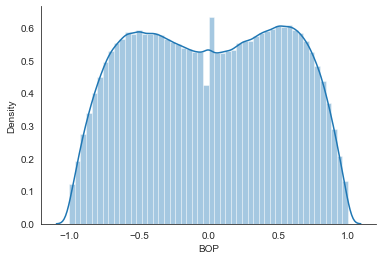

In [324]:
q = 0.0005
with sns.axes_style("white"):
    sns.distplot(data.BOP.clip(lower=data.BOP.quantile(q),
                               upper=data.BOP.quantile(1-q)))
    sns.despine()

### Commodity Channel Index (CCI)

The Commodity Channel Index (CCI) measures the difference between the current *typical* price, computed as the average of current low, high and close price and the historical average price. A positive (negative) CCI indicates that price is above (below) the historic average. When CCI is below zero, the price is below the hsitoric average. It is computed as:

$$
\begin{align*}
\bar{P_t}&=\frac{P_t^H+P_t^L+P_t^C}{3}\\
\text{CCI}_t & =\frac{\bar{P_t} - \text{SMA}(T)_t}{0.15\sum_{t=i}^T |\bar{P_t}-\text{SMA}(N)_t|/T}
\end{align*}
$$

In [325]:
df = price_sample.loc['2013', ['high', 'low', 'close']]

In [326]:
df['CCI'] = talib.CCI(high=df.high,
                      low=df.low,
                      close=df.close,
                      timeperiod=14)

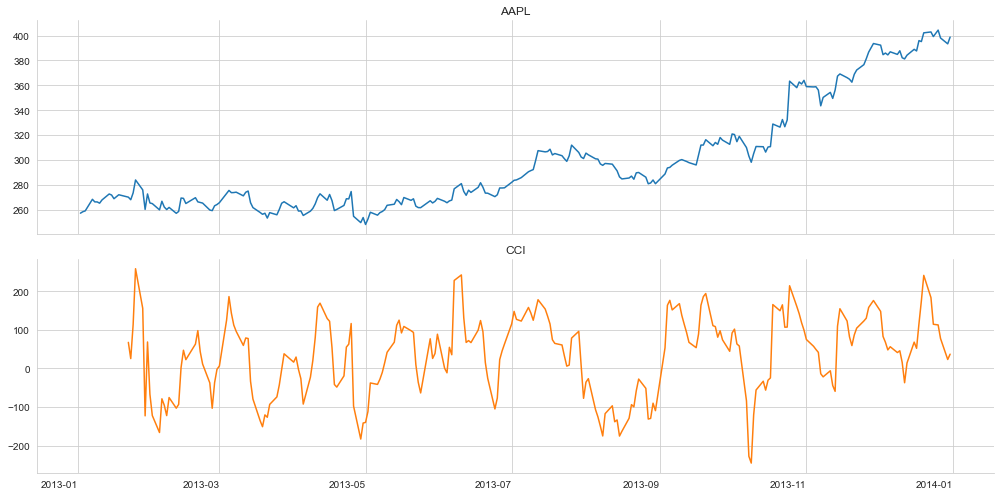

In [327]:
axes = df[['close', 'CCI']].plot(figsize=(14, 7), 
                                 rot=0, 
                                 subplots=True, 
                                 title=['AAPL', 'CCI'], 
                                 legend=False)
axes[1].set_xlabel('')
sns.despine()
plt.tight_layout()

In [328]:
data['CCI'] = (by_ticker
               .apply(lambda x: talib.CCI(x.high,
                                          x.low,
                                          x.close,
                                          timeperiod=14)))

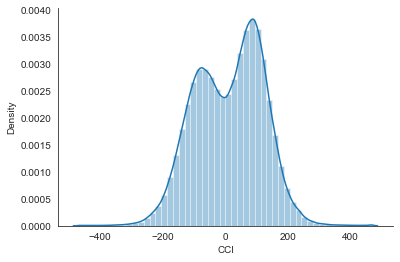

In [329]:
with sns.axes_style('white'):
    sns.distplot(data.CCI)
    sns.despine();

### Moving Average Convergence/Divergence (MACD)

Moving Average Convergence Divergence (MACD) is a trend-following (lagging) momentum indicator that shows the relationship between two moving averages of a security’s price. It is calculated by subtracting the 26-period Exponential Moving Average (EMA) from the 12-period EMA.

The TA-Lib implementation returns the MACD value and its signal line, which is the 9-day EMA of the MACD. In addition, the MACD-Histogram measures the distance between the indicator and its signal line.

In [330]:
df = price_sample.loc['2013', ['close']]

In [331]:
macd, macdsignal, macdhist = talib.MACD(df.close,
                                        fastperiod=12,
                                        slowperiod=26,
                                        signalperiod=9)
df['MACD'] = macd
df['MACDSIG'] = macdsignal
df['MACDHIST'] = macdhist

In [332]:
def compute_macd(close, fastperiod=12, slowperiod=26, signalperiod=9):
    macd, macdsignal, macdhist = talib.MACD(close,
                                            fastperiod=fastperiod,
                                            slowperiod=slowperiod,
                                            signalperiod=signalperiod)
    return pd.DataFrame({'MACD': macd,
                         'MACD_SIGNAL': macdsignal,
                         'MACD_HIST': macdhist},
                        index=close.index)

In [333]:
data = (data.join(data
                  .groupby(level='ticker')
                  .close
                  .apply(compute_macd)))

In [334]:
macd_indicators = ['MACD', 'MACD_SIGNAL', 'MACD_HIST']

In [335]:
data[macd_indicators].corr()

,MACD,MACD_SIGNAL,MACD_HIST
MACD,1.000000,0.954498,0.347655
MACD_SIGNAL,0.954498,1.000000,0.052220
MACD_HIST,0.347655,0.052220,1.000000


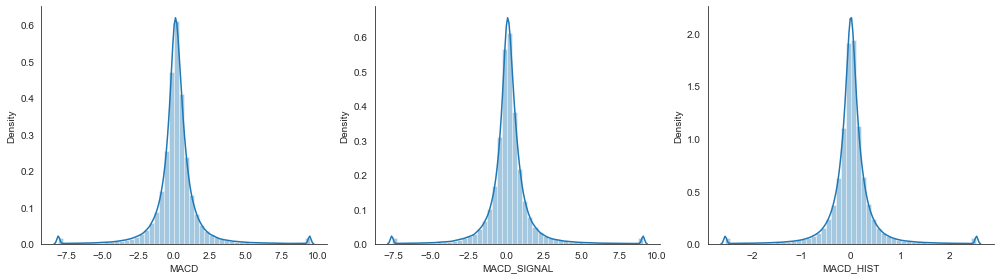

In [336]:
q = .005
with sns.axes_style('white'):
    fig, axes = plt.subplots(ncols=3, figsize=(14, 4))
    df_ = data[macd_indicators]
    df_ = df_.clip(df_.quantile(q), 
                   df_.quantile(1-q), axis=1)
    for i, indicator in enumerate(macd_indicators):
        sns.distplot(df_[indicator], ax=axes[i])
    sns.despine()
    fig.tight_layout();

### Chande Momentum Oscillator (CMO)

The Chande Momentum Oscillator (CMO) intends to measure momentum on both up and down days. It is calculated as the difference between the sum of gains and losses over at time period T, divided by the sum of all price movement over the same period. It oscillates between +100 and -100.

In [337]:
df = price_sample.loc['2013', ['close']]

In [338]:
df['CMO'] = talib.CMO(df.close, timeperiod=14)

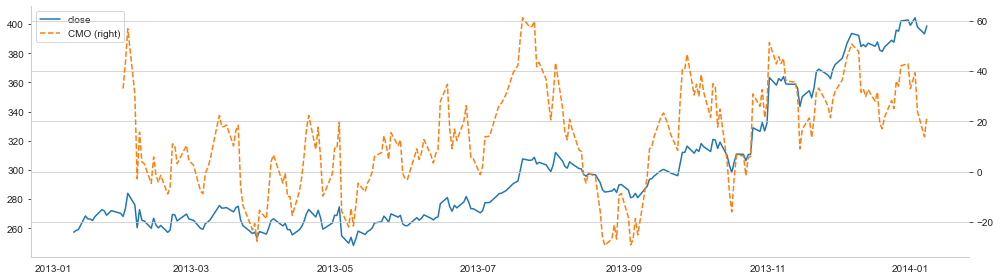

In [339]:
ax = df.plot(figsize=(14, 4), rot=0, secondary_y=['CMO'], style=['-', '--'])

ax.set_xlabel('')
sns.despine()
plt.tight_layout()

In [340]:
data['CMO'] = (by_ticker
                .apply(lambda x: talib.CMO(x.close,
                                           timeperiod=14)))

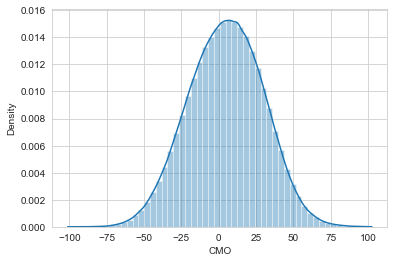

In [341]:
sns.distplot(data.CMO);

### Money Flow Index

The Money Flow Index (MFI) incorporates price and volume information to identify overbought or oversold conditions.  The indicator is typically calculated using 14 periods of data. An MFI reading above 80 is considered overbought and an MFI reading below 20 is considered oversold.

In [342]:
df = price_sample.loc['2013', ['high', 'low', 'close', 'volume']]

In [343]:
df['MFI'] = talib.MFI(df.high, 
                      df.low, 
                      df.close, 
                      df.volume, 
                      timeperiod=14)

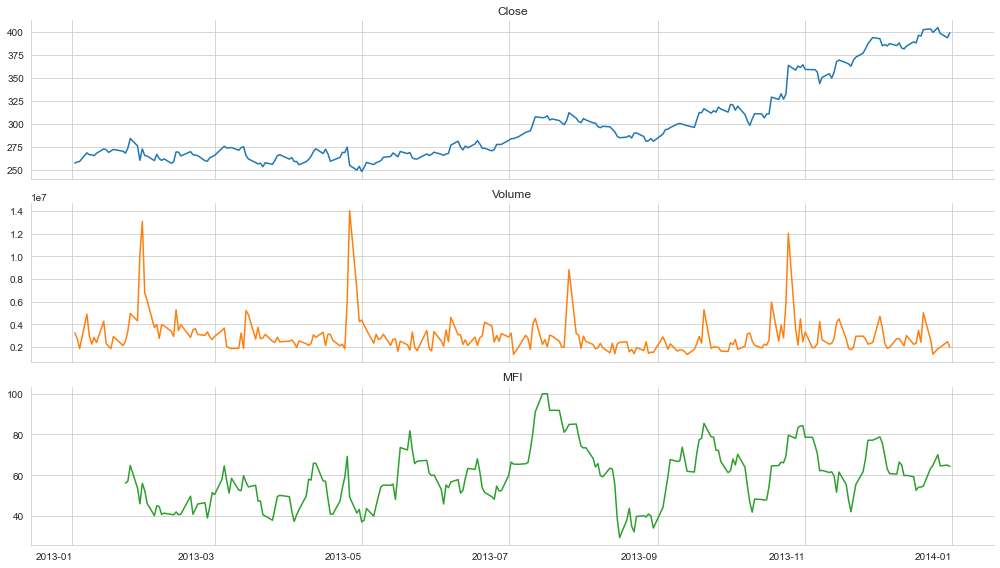

In [344]:
axes = df[['close', 'volume', 'MFI']].plot(figsize=(14, 8),
                                           rot=0,
                                           subplots=True,
                                           title=['Close', 'Volume', 'MFI'],
                                           legend=False)
axes[-1].set_xlabel('')
sns.despine()
plt.tight_layout()

In [345]:
data['MFI'] = (by_ticker
               .apply(lambda x: talib.MFI(x.high,
                                          x.low,
                                          x.close,
                                          x.volume,
                                          timeperiod=14)))

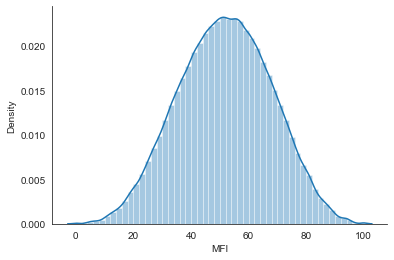

In [346]:
with sns.axes_style('white'):
    sns.distplot(data.MFI)
    sns.despine()

### Relative Strength Index

RSI compares the magnitude of recent price changes across stocks to identify stocks as overbought or oversold. A high RSI (usually above 70) indicates overbought and a low RSI (typically below 30) indicates oversold. It first computes the average price change for a given number (often 14) of prior trading days with rising and falling prices, respectively as $\text{up}_t$ and $\text{down}_t$. Then, the RSI is computed as:
$$
\text{RSI}_t=100-\frac{100}{1+\frac{\text{up}_t}{\text{down}_t}}
$$



In [347]:
df = price_sample.loc['2013', ['close']]

In [348]:
df['RSI'] = talib.RSI(df.close, timeperiod=14)

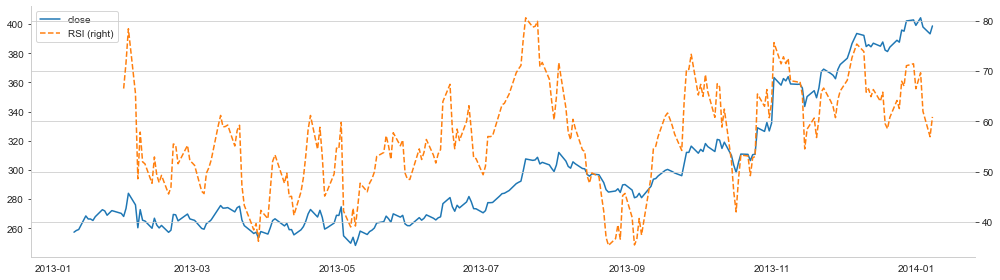

In [349]:
ax = df.plot(figsize=(14, 4), rot=0, secondary_y=['RSI'], style=['-', '--'])
ax.set_xlabel('')
sns.despine()
plt.tight_layout()

In [350]:
data['RSI'] = (by_ticker
               .apply(lambda x: talib.RSI(x.close,
                                          timeperiod=14)))

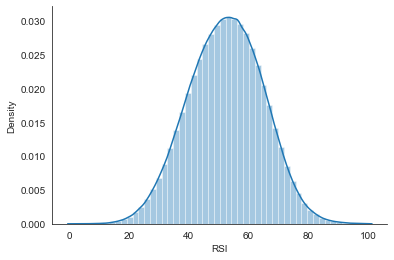

In [351]:
with sns.axes_style('white'):
    sns.distplot(data.RSI)
    sns.despine();

#### Stochastic RSI (STOCHRSI)

The Stochastic Relative Strength Index (STOCHRSI) is based on the RSI just described and intends to identify crossovers as well as overbought and oversold conditions. It compares the distance of the current RSI to the lowest RSI over a given time period T to the maximum range of values the RSI has assumed for this period. It is computed as follows:

$$
\text{STOCHRSI}_t= \frac{\text{RSI}_t-\text{RSI}_t^L(T)}{\text{RSI}_t^H(T)-\text{RSI}_t^L(T)}
$$

The TA-Lib implementation offers more flexibility than the original "Unsmoothed stochastic RSI" version by Chande and Kroll (1993). To calculate the original indicator, keep the `timeperiod` and `fastk_period` equal. 

The return value `fastk` is the unsmoothed RSI. The `fastd_period` is used to compute a smoothed STOCHRSI, which  is returned as `fastd`. If you do not care about STOCHRSI smoothing, just set `fastd_period` to 1 and ignore the `fastd` output.

Reference: "Stochastic RSI and Dynamic Momentum Index" by Tushar Chande and Stanley Kroll Stock&Commodities V.11:5 (189-199)


In [352]:
df = price_sample.loc['2013', ['close']]

In [353]:
fastk, fastd = talib.STOCHRSI(df.close,
                              timeperiod=14, 
                              fastk_period=14, 
                              fastd_period=3, 
                              fastd_matype=0)
df['fastk'] = fastk
df['fastd'] = fastd

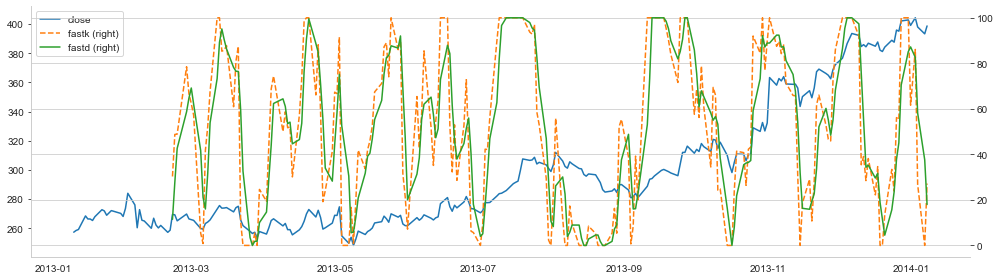

In [354]:
ax = df.plot(figsize=(14, 4),
             rot=0,
             secondary_y=['fastk', 'fastd'], style=['-', '--'])
ax.set_xlabel('')
sns.despine()
plt.tight_layout()

In [355]:
data['STOCHRSI'] = (by_ticker.apply(lambda x: talib.STOCHRSI(x.close,
                                                             timeperiod=14,
                                                             fastk_period=14,
                                                             fastd_period=3,
                                                             fastd_matype=0)[0]))

### Stochastic (STOCH)

A stochastic oscillator is a momentum indicator comparing a particular closing price of a security to a range of its prices over a certain period of time. Stochastic oscillators are based on the idea that closing prices should confirm the trend.

For stochastic (STOCH), there are four different lines: `FASTK`, `FASTD`, `SLOWK` and `SLOWD`. The `D` is the signal line usually drawn over its corresponding `K` function.

$$
\begin{align*}
& K^\text{Fast}(T_K) & = &\frac{P_t-P_{T_K}^L}{P_{T_K}^H-P_{T_K}^L}* 100 \\
& D^\text{Fast}(T_{\text{FastD}}) & = & \text{MA}(T_{\text{FastD}})[K^\text{Fast}]\\
& K^\text{Slow}(T_{\text{SlowK}}) & = &\text{MA}(T_{\text{SlowK}})[K^\text{Fast}]\\
& D^\text{Slow}(T_{\text{SlowD}}) & = &\text{MA}(T_{\text{SlowD}})[K^\text{Slow}]
\end{align*}
$$
  

The $P_{T_K}^L$, $P_{T_K}^H$, and $P_{T_K}^L$ are the extreme values among the last $T_K$ period.
 $K^\text{Slow}$ and $D^\text{Fast}$ are equivalent when using the same period. 

In [356]:
df = price_sample.loc['2013', ['high', 'low', 'close']]

In [357]:
slowk, slowd = talib.STOCH(df.high,
                           df.low,
                           df.close,
                           fastk_period=14,
                           slowk_period=3,
                           slowk_matype=0,
                           slowd_period=3,
                           slowd_matype=0)
df['STOCH'] = slowd / slowk

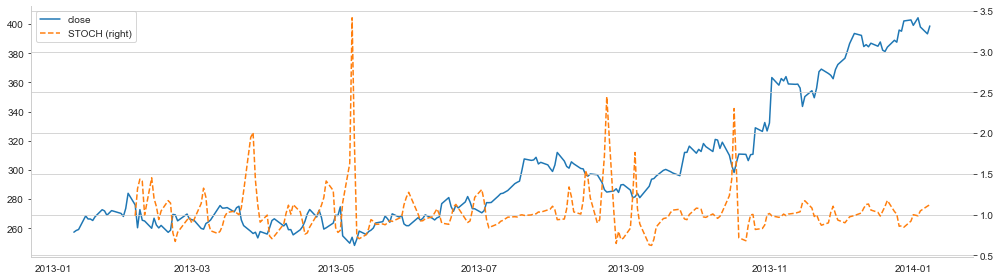

In [358]:
ax = df[['close', 'STOCH']].plot(figsize=(14, 4),
                                 rot=0,
                                 secondary_y='STOCH', style=['-', '--'])
ax.set_xlabel('')
sns.despine()
plt.tight_layout()

In [359]:
def compute_stoch(x, fastk_period=14, slowk_period=3, 
                  slowk_matype=0, slowd_period=3, slowd_matype=0):
    slowk, slowd = talib.STOCH(x.high, x.low, x.close,
                           fastk_period=fastk_period,
                           slowk_period=slowk_period,
                           slowk_matype=slowk_matype,
                           slowd_period=slowd_period,
                           slowd_matype=slowd_matype)
    return slowd/slowk-1

In [360]:
data['STOCH'] = by_ticker.apply(compute_stoch)
data.loc[data.STOCH.abs() > 1e5, 'STOCH'] = np.nan

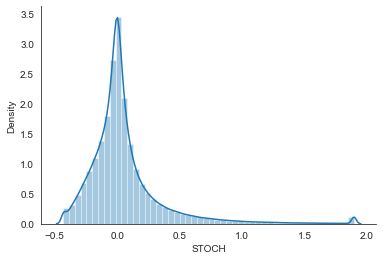

In [361]:
q = 0.005
with sns.axes_style('white'):
    sns.distplot(data.STOCH.clip(lower=data.STOCH.quantile(q),
                             upper=data.STOCH.quantile(1-q)));

    sns.despine();

### Ultimate Oscillator (ULTOSC)

The Ultimate Oscillator (ULTOSC), developed by Larry Williams, measures the average difference of the current close to the previous lowest price over three time frames (default: 7, 14, and 28) to avoid overreacting to short-term price changes and incorporat short, medium, and long-term market trends. It first computes the buying pressure, $\text{BP}_t$, then sums it over the three periods $T_1, T_2, T_3$, normalized by the True Range ($\text{TR}_t$.
$$
\begin{align*}
\text{BP}_t & = P_t^\text{Close}-\min(P_{t-1}^\text{Close}, P_t^\text{Low})\\ 
\text{TR}_t & = \max(P_{t-1}^\text{Close}, P_t^\text{High})-\min(P_{t-1}^\text{Close}, P_t^\text{Low})
\end{align*}
$$

ULTOSC is then computed as a weighted average over the three periods as follows:
$$
\begin{align*}
\text{Avg}_t(T) & = \frac{\sum_{i=0}^{T-1} \text{BP}_{t-i}}{\sum_{i=0}^{T-1} \text{TR}_{t-i}}\\
\text{ULTOSC}_t & = 100*\frac{4\text{Avg}_t(7) + 2\text{Avg}_t(14) + \text{Avg}_t(28)}{4+2+1}
\end{align*}
$$

In [362]:
df = price_sample.loc['2013', ['high', 'low', 'close']]

In [363]:
df['ULTOSC'] = talib.ULTOSC(df.high,
                            df.low,
                            df.close,
                            timeperiod1=7,
                            timeperiod2=14,
                            timeperiod3=28)

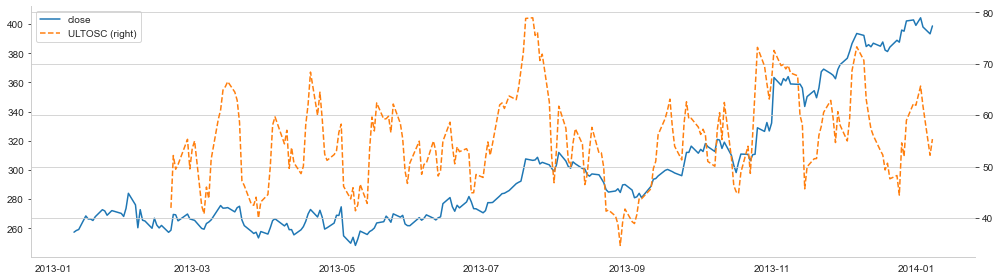

In [364]:
ax = df[['close', 'ULTOSC']].plot(figsize=(14, 4),
                                  rot=0,
                                  secondary_y='ULTOSC', style=['-', '--'])
ax.set_xlabel('')
sns.despine()
plt.tight_layout()

In [365]:
def compute_ultosc(x, timeperiod1=7, timeperiod2=14, timeperiod3=28):
    return talib.ULTOSC(x.high,
                        x.low,
                        x.close,
                        timeperiod1=timeperiod1,
                        timeperiod2=timeperiod2,
                        timeperiod3=timeperiod3)

In [366]:
data['ULTOSC'] = by_ticker.apply(compute_ultosc)

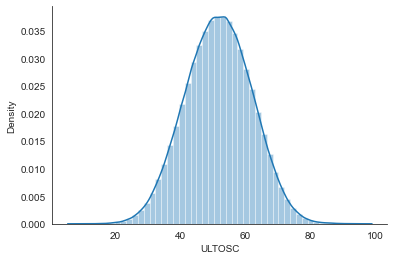

In [367]:
with sns.axes_style('white'):
    sns.distplot(data.ULTOSC)
    sns.despine();

### Williams' %R (WILLR)

Williams %R, also known as the Williams Percent Range, is a momentum indicator that moves between 0 and -100 and measures overbought and oversold levels to identify entry and exit points. It is similar to the Stochastic oscillator and compares the current closing price $P_t^\text{Close}$ to the range of highest ($P_T^\text{High}$) and lowest ($P_T^\text{Low}$) prices over the last T periods (typically 14). The indicators is computed as:

$$
\text{WILLR}_t = \frac{P_T^\text{High}-P_t^\text{Close}}{P_T^\text{High}-P_T^\text{Low}}
$$


In [368]:
df = price_sample.loc['2013', ['high', 'low', 'close']]

In [369]:
df['WILLR'] = talib.WILLR(df.high,
                          df.low,
                          df.close,
                          timeperiod=14)

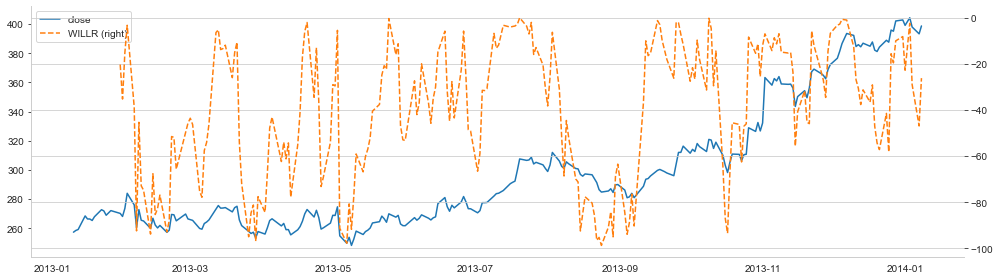

In [370]:
ax = df[['close', 'WILLR']].plot(figsize=(14, 4),
                                 rot=0,
                                 secondary_y='WILLR', style=['-', '--'])
ax.set_xlabel('')
sns.despine()
plt.tight_layout()

In [371]:
data['WILLR'] = by_ticker.apply(lambda x: talib.WILLR(x.high, x.low, x.close, timeperiod=14))

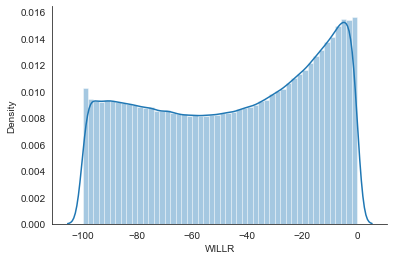

In [372]:
with sns.axes_style('white'):
    sns.distplot(data.WILLR)
    sns.despine();

## Volume Indicators

|Function|             Name|
|:---|:---|
|AD|                   Chaikin A/D Line|
|ADOSC|                Chaikin A/D Oscillator|
|OBV|                  On Balance Volume|

### Chaikin A/D Line

The Chaikin Advance/Decline or Accumulation/Distribution Line (AD) is a volume-based indicator designed to measure the cumulative flow of money into and out of an asset. The indicator assumes that the degree of buying or selling pressure can be determined by the location of the close, relative to the high and low for the period. There is buying (sellng) pressure when a stock closes in the upper (lower) half of a period's range. The intention is to signal a change in direction when the indicator diverges from the security price.

The Accumulation/Distribution Line is a running total of each period's Money Flow Volume. It is calculated as follows:

1. The Money Flow Multiplier (MFI) is the relationship of the close to the high-low range:
2. The MFI is multiplied by the period's volume $V_t$ to come up with a Money Flow Volume (MFV). 
3. A running total of the Money Flow Volume forms the Accumulation Distribution Line:
$$
\begin{align*}
&\text{MFI}_t&=\frac{P_t^\text{Close}-P_t^\text{Low}}{P_t^\text{High}-P_t^\text{Low}}\\
&\text{MFV}_t&=\text{MFI}_t \times V_t\\
&\text{AD}_t&=\text{AD}_{t-1}+\text{MFV}_t
\end{align*}
$$

In [373]:
df = price_sample.loc['2013', ['high', 'low', 'close', 'volume']]

In [374]:
df['AD'] = talib.AD(df.high,
                    df.low,
                    df.close,
                    df.volume)

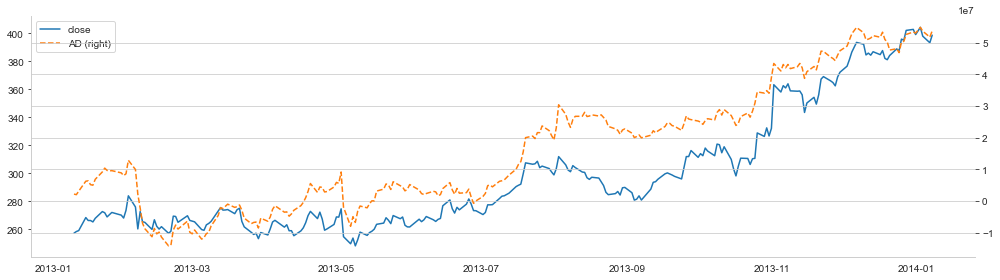

In [375]:
ax = df[['close', 'AD']].plot(figsize=(14, 4),
                              rot=0,
                              secondary_y='AD', style=['-', '--'])

ax.set_xlabel('')
sns.despine()
plt.tight_layout()

In [376]:
data['AD'] = by_ticker.apply(lambda x: talib.AD(x.high, x.low, x.close, x.volume)/x.volume.mean())

In [377]:
data.AD.replace((np.inf, -np.inf), np.nan).dropna().describe()

count    1.383020e+06
mean     3.043109e+01
std      4.592564e+01
min     -2.027774e+02
25%      1.361733e+00
50%      1.963339e+01
75%      5.392881e+01
max      5.182947e+02
Name: AD, dtype: float64

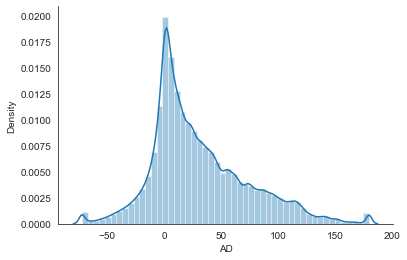

In [378]:
q = 0.005
AD = data.AD.replace((np.inf, -np.inf), np.nan).dropna()
with sns.axes_style('white'):
    sns.distplot(AD.clip(lower=AD.quantile(q),
                     upper=AD.quantile(1-q)));

    sns.despine();

### Chaikin A/D Oscillator (ADOSC)

The Chaikin A/D Oscillator (ADOSC) is the Moving Average Convergence Divergence indicator (MACD) applied to the Chaikin A/D Line. The Chaikin Oscillator intends to predict changes in the Accumulation/Distribution Line.

It is computed as the difference between the 3-day exponential moving average and the 10-day exponential moving average of the Accumulation/Distribution Line.

In [379]:
df = price_sample.loc['2013', ['high', 'low', 'close', 'volume']]

In [380]:
df['ADOSC'] = talib.ADOSC(df.high,
                          df.low,
                          df.close,
                          df.volume,
                          fastperiod=3,
                          slowperiod=10)

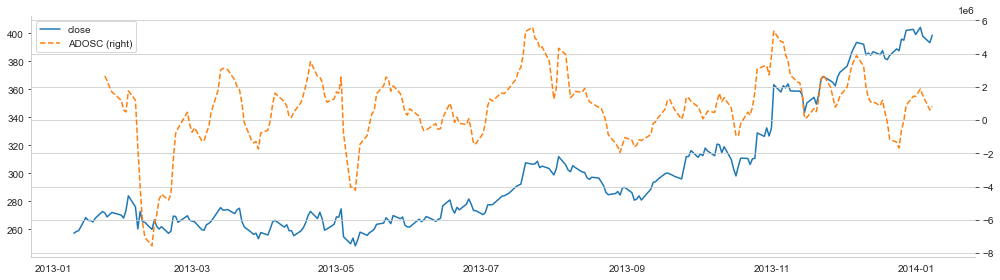

In [381]:
ax = df[['close', 'ADOSC']].plot(figsize=(14, 4),
                                 rot=0,
                                 secondary_y='ADOSC', style=['-', '--'])

ax.set_xlabel('')
sns.despine()
plt.tight_layout()

In [382]:
data['ADOSC'] = by_ticker.apply(lambda x: talib.ADOSC(x.high,
                                                      x.low,
                                                      x.close,
                                                      x.volume,
                                                      fastperiod=3,
                                                      slowperiod=10)/x.rolling(14).volume.mean())

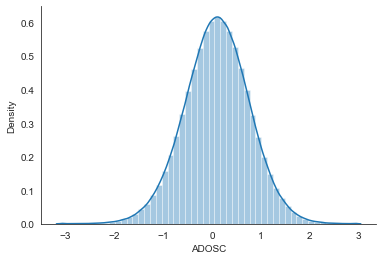

In [383]:
q = 0.0001
with sns.axes_style('white'):
    sns.distplot(data.ADOSC.clip(lower=data.ADOSC.quantile(q),
                             upper=data.ADOSC.quantile(1-q)))
    sns.despine();

### On Balance Volume (OBV)

The On Balance Volume indicator (OBV) is a cumulative momentum indicator that relates volume to price change. It assumes that OBV changes precede price changes because smart money can be seen flowing into the security by a rising OBV. When the public then moves into the security, both the security and OBV will rise.

The current OBV is computed by adding (subtracting) the current volume to the last OBV if the security closes higher (lower) than the previous close.

$$
\text{OBV}_t = 
\begin{cases}
\text{OBV}_{t-1}+V_t & \text{if }P_t>P_{t-1}\\
\text{OBV}_{t-1}-V_t & \text{if }P_t<P_{t-1}\\
\text{OBV}_{t-1} & \text{otherwise}
\end{cases}
$$

In [384]:
df = price_sample.loc['2013', ['close', 'volume']]

In [385]:
df['OBV'] = talib.OBV(df.close,
                      df.volume)

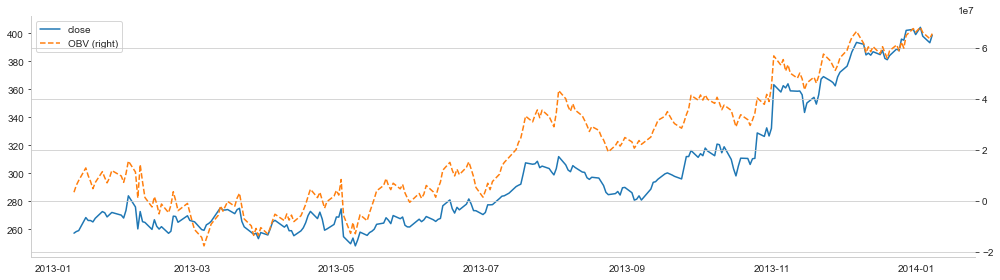

In [386]:
ax = df[['close', 'OBV']].plot(figsize=(14, 4),
                               rot=0,
                               secondary_y='OBV', style=['-', '--'])
ax.set_xlabel('')
sns.despine()
plt.tight_layout()

In [387]:
data['OBV'] = by_ticker.apply(lambda x: talib.OBV(x.close,
                                                  x.volume)/x.expanding().volume.mean())

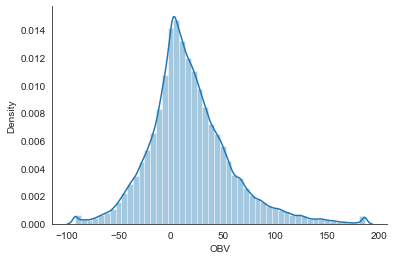

In [388]:
q = 0.0025
with sns.axes_style('white'):
    sns.distplot(data.OBV.clip(lower=data.OBV.quantile(q),
                               upper=data.OBV.quantile(1-q)))
    sns.despine()

## Volatility Indicators

|Function|             Name|
|:---|:---|
|TRANGE|               True Range|
|ATR|                  Average True Range|
|NATR|                 Normalized Average True Range|

### ATR

The Average True Range indicator (ATR) shows volatility of the market. It was introduced by Welles Wilder (1978)  and has been used as a component of numerous other indicators since. It aims to anticipate changes in trend such that the higher its value, the higher the probability of a trend change; the lower the indicator’s value, the weaker the current trend.

It is computed as the simple moving average for a period T of the True Range (TRANGE), which measures volatility as the absolute value of the largest recent trading range:
$$
\text{TRANGE}_t = \max\left[P_t^\text{High} - P_t^\text{low}, \left| P_t^\text{High} - P_{t-1}^\text{Close}\right|, \left| P_t^\text{low} - P_{t-1}^\text{Close}\right|\right]
$$

In [389]:
df = price_sample.loc['2013', ['high', 'low', 'close']]

In [390]:
df['ATR'] = talib.ATR(df.high,
                      df.low,
                      df.close,
                      timeperiod=14)

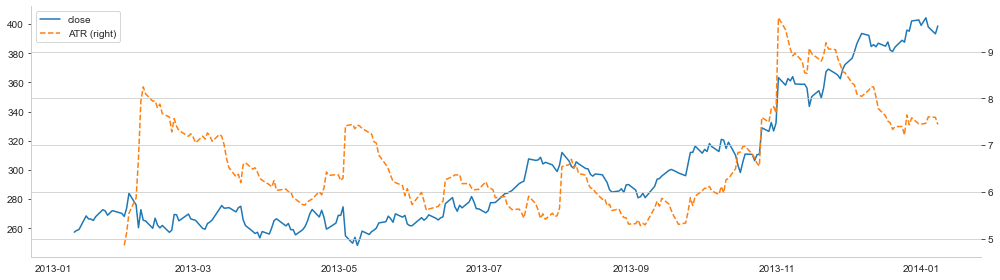

In [391]:
ax = df[['close', 'ATR']].plot(figsize=(14, 4),
                          rot=0,
                          secondary_y='ATR', style=['-', '--'])

ax.set_xlabel('')
sns.despine()
plt.tight_layout()

In [392]:
data['ATR'] = by_ticker.apply(lambda x: talib.ATR(x.high,
                                                  x.low,
                                                  x.close,
                                                  timeperiod=14)/x.rolling(14).close.mean())

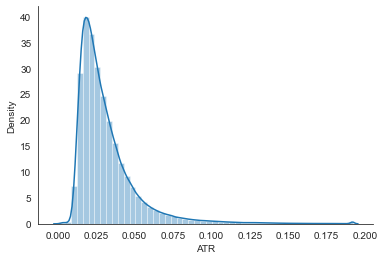

In [393]:
q = 0.001
with sns.axes_style('white'):
    sns.distplot(data.ATR.clip(upper=data.ATR.quantile(1-q)))
    sns.despine()

### NATR

The Normalized Average True Range (NATR) is a normalized version of the ATR computed as follows:

$$
\text{NATR}_t = \frac{\text{ATR}_t(T)}{P_t^\text{Close}} * 100
$$

Normalization make the ATR function more relevant in the folllowing scenarios:
- Long term analysis where the price changes drastically.
- Cross-market or cross-security ATR comparison.

In [394]:
df = price_sample.loc['2013', ['high', 'low', 'close']]

In [395]:
df['NATR'] = talib.NATR(df.high,
                        df.low,
                        df.close,
                        timeperiod=14)

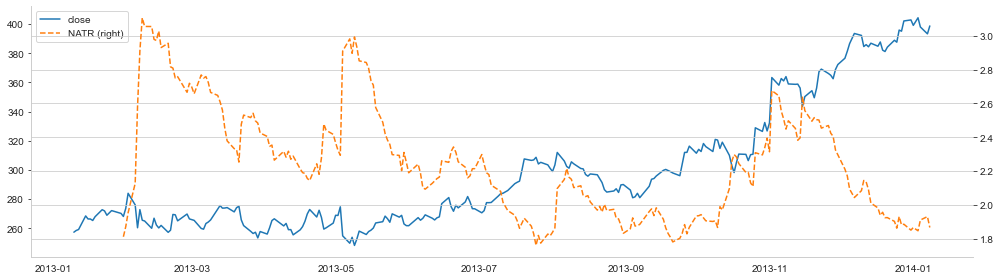

In [396]:
ax = df[['close', 'NATR']].plot(figsize=(14, 4),
                           rot=0,
                           secondary_y='NATR', style=['-', '--'])

ax.set_xlabel('')
sns.despine()
plt.tight_layout()

## Rolling Factor Betas

In [428]:
stonks = data.index.get_level_values('ticker').unique()
rets = simple_returns.to_frame('ret_01').loc[idx[:, stonks], :]

In [441]:
times = data.index.get_level_values('date').unique()

In [404]:
factor_data = (web.DataReader('F-F_Research_Data_5_Factors_2x3_daily', 'famafrench', 
                              start=1998)[0].rename(columns={'Mkt-RF': 'MARKET'}))
factor_data.index.names = ['date']

In [405]:
factors = factor_data.columns[:-1]
factors

Index(['MARKET', 'SMB', 'HML', 'RMW', 'CMA'], dtype='object')

In [410]:
t = 1
ret = f'ret_{t:02}'
windows = [63, 252]

In [442]:
for window in windows:
    print(window)
    betas = []
    for ticker, df in rets.groupby('ticker', group_keys=False):
        model_data = df.merge(factor_data, on='date').dropna()
        model_data[ret] -= model_data.RF
        
        rolling_ols = RollingOLS(endog=model_data[ret], 
                                 exog=sm.add_constant(model_data[factors]), window=window)
        factor_model = rolling_ols.fit(params_only=True).params.rename(columns={'const':'ALPHA'})
        result = factor_model.assign(ticker=ticker).set_index('ticker', append=True)
        betas.append(result)
    betas = pd.concat(betas).rename(columns=lambda x: f'{x}_{window:02}').sort_index()
    data = data.join(betas.loc[idx[times, :], :])

63
252


## Time Period Flags

In [443]:
dates = data.index.get_level_values('date')

In [449]:
data['month'] = dates.month.values.astype(np.uint8)
data['weekday'] = dates.weekday.values.astype(np.uint8)

## Persist results

In [450]:
data = (data
        .drop(['open', 'high', 'low', 'close', 'volume'], axis=1)
        .replace((np.inf, -np.inf), np.nan))

In [451]:
data.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 1383053 entries, (Timestamp('2006-01-03 00:00:00'), 'A') to (Timestamp('2016-12-29 00:00:00'), 'ZTS')
Data columns (total 52 columns):
 #   Column           Non-Null Count    Dtype  
---  ------           --------------    -----  
 0   dollar_vol_rank  1383053 non-null  float64
 1   ret_01           1381655 non-null  float64
 2   ret_03           1378992 non-null  float64
 3   ret_05           1376426 non-null  float64
 4   ret_10           1370266 non-null  float64
 5   ret_21           1357487 non-null  float64
 6   ret_42           1335340 non-null  float64
 7   ret_63           1314565 non-null  float64
 8   ret_126          1257666 non-null  float64
 9   ret_252          1155277 non-null  float64
 10  ret_fwd          1383053 non-null  float64
 11  BB_UP            1358598 non-null  float64
 12  BB_LOW           1358598 non-null  float64
 13  BB_SQUEEZE       1358598 non-null  float64
 14  HT               1314565 non-null  float64

In [452]:
with pd.HDFStore('stock_prices.h5') as store:
    store.put('model_data', data)